In [1]:
import importlib
from jax.scipy.linalg import inv, det, svd
import jax.numpy as jnp
from jax import random, jit, lax
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import jax
from jax_models import visualize_observations, KuramotoSivashinsky, generate_true_states, generate_gc_localization_matrix, Lorenz96
from jax_filters import ensrf_steps
from jax.tree_util import Partial

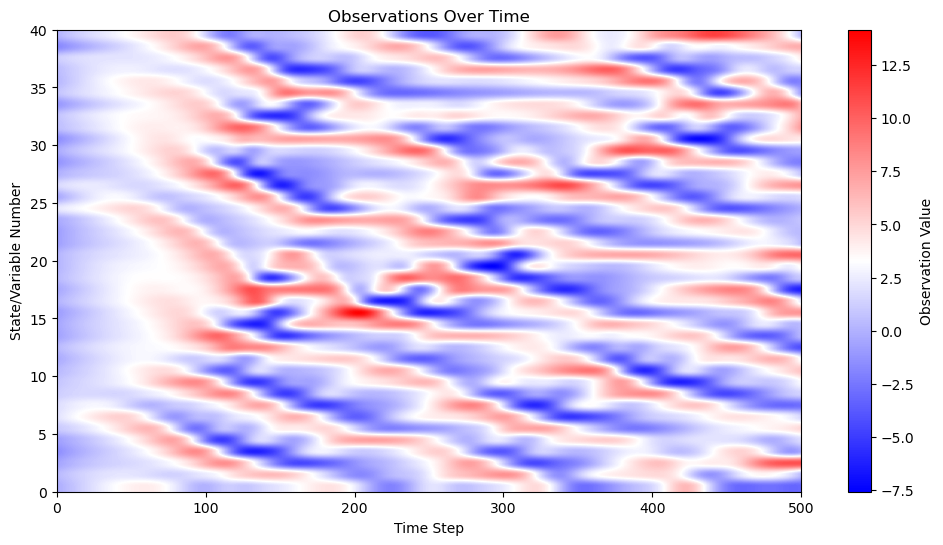

In [11]:

# Parameters
F = 8.0
dt = 0.01
num_steps = 500  # Number of time steps
n_timesteps = num_steps
J0 = 0
n = 40  # Number of state variables
Q = 0.1 * jnp.eye(n)  # Process noise covariance
R_matrix = 0.1 * jnp.eye(n)#make_spd_matrix(n)  # Generating a symmetric positive definite matrix for R
R = jnp.array(R_matrix)  # Observation noise covariance
H = jnp.eye(n)  # Observation matrix


#N = 10
n_ensemble = 20
observation_interval = 5
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state

l96_model = Lorenz96(dt = dt, F = 8)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
key = random.PRNGKey(0)

observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

# Visualize the observations
visualize_observations(true_states)

In [4]:
states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation, run_key)


NameError: name 'ensemble_init' is not defined

In [9]:
import pickle
import os
from datetime import datetime
from tqdm import tqdm

radii = [2,5, 10,25, 50, 100]
inflations = [1.0, 1.05, 1.1, 1.2, 1.3, 1.5]
num_trials = 10
ensemble_sizes = [5, 10,20, 30,40]
num_steps = 1000

# radii = [2,5]
# inflations = [1.0]
# num_trials = 2
# ensemble_sizes = [10]

observation_times = jnp.arange(0, num_steps, observation_interval)

# Initialize random key for reproducibility
key = random.PRNGKey(0)

# Initial state
initial_state = random.normal(key, (n,))

# Initialize data structures for results
std_errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}

for trial in tqdm(range(num_trials), desc="Running Trials"):
    key, trial_key = random.split(key) 

    print(f"Trial {trial}")
    observations, true_states = generate_true_states(trial_key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
    observed_true_states = true_states[observation_times] #only comparing metrics for analysis steps
    for radius in radii:
        local_mat = generate_gc_localization_matrix(n, radius)
        for inflation in inflations:
            for n_ensemble in ensemble_sizes:
                key, run_key = random.split(key)  # Split the key for ensrf_steps1
                ensemble_init = random.multivariate_normal(run_key, initial_state, Q, (n_ensemble,)).T
                states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation, run_key)
                # expected shape (n_timesteps, state_dimension, n_ensemble)
                average_state = jnp.mean(states, axis=2)  # Calculate the mean along the ensemble dimension
                observed_average_state = average_state[observation_times] # only comparing metrics for analysis steps
                error = jnp.sqrt(jnp.mean((observed_average_state - observed_true_states) ** 2, axis=1))
                errors[(radius, inflation, n_ensemble)].append(error)
                observed_states = states[observation_times, :, :]
                std_dev = jnp.mean(jnp.std(observed_states, axis = 2), axis = 1)  # Standard deviation across all ensemble members and state dimensions at observation times
                std_errors[(radius, inflation, n_ensemble)].append(std_dev)

# Preparing data for saving
all_data = {
    'std_errors': std_errors,
    'errors': errors,
    'parameters': {
        'radii': radii,
        'inflations': inflations,
        'ensemble_sizes': ensemble_sizes,
        'num_trials': num_trials,
        'filter_params': (H,Q,R, observation_interval, num_steps)
    }
}

# File saving path
directory = '/central/home/eluk/variational_filtering/experiment_data/'
filename = f'l96_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
file_path = os.path.join(directory, filename)

with open(file_path, 'wb') as f:

    pickle.dump(all_data, f)

Running Trials:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Trial 0


Running Trials:  10%|██████▊                                                             | 1/10 [00:07<01:09,  7.69s/it]

Trial 1


Running Trials:  20%|█████████████▌                                                      | 2/10 [00:14<00:59,  7.38s/it]

Trial 2


Running Trials:  30%|████████████████████▍                                               | 3/10 [00:21<00:50,  7.27s/it]

Trial 3


Running Trials:  40%|███████████████████████████▏                                        | 4/10 [00:29<00:43,  7.22s/it]

Trial 4


Running Trials:  50%|██████████████████████████████████                                  | 5/10 [00:36<00:36,  7.25s/it]

Trial 5


Running Trials:  60%|████████████████████████████████████████▊                           | 6/10 [00:43<00:29,  7.29s/it]

Trial 6


Running Trials:  70%|███████████████████████████████████████████████▌                    | 7/10 [00:51<00:22,  7.34s/it]

Trial 7


Running Trials:  80%|██████████████████████████████████████████████████████▍             | 8/10 [00:58<00:14,  7.38s/it]

Trial 8


Running Trials:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [01:06<00:07,  7.40s/it]

Trial 9


Running Trials: 100%|███████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.36s/it]


In [10]:
%env XLA_FLAGS=--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32

num_devices = jax.local_device_count()
print(f"Running on {num_devices} devices")
print(jax.devices())

env: XLA_FLAGS=--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32
Running on 1 devices
[CpuDevice(id=0)]


In [ ]:
num_cpus = os.cpu_count()
print(f"Number of CPUs available: {num_cpus}")

In [ ]:
#!lscpu

In [8]:
# import os
# import pickle
# from datetime import datetime
# from tqdm import tqdm
# import multiprocessing
# from itertools import product
# import numpy as jnp
# import jax.numpy as jnp
# from jax import random


# def experiment_worker(params):
#     radius, inflation, n_ensemble, observations, observed_true_states, key = params
#     local_mat = generate_gc_localization_matrix(n, radius)
#     ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
#     states, _ = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation)
#     print(states)
#     observed_states = states[observation_times, :, :]
#     std_dev = jnp.mean(jnp.std(observed_states, axis=2), axis=1)
#     error = jnp.sqrt(jnp.mean((jnp.mean(observed_states, axis=2) - observed_true_states) ** 2, axis=1))
#     return radius, inflation, n_ensemble, error, std_dev

# def run_trial(trial_key):
#     observations, true_states = generate_true_states(trial_key, num_steps, n, initial_state, H, Q, R, ks_step, observation_interval)
#     observed_true_states = true_states[observation_times]
#     all_params = [(radius, inflation, ensemble_size, observations, observed_true_states, trial_key) for radius, inflation, ensemble_size in product(radii, inflations, ensemble_sizes)]
#     with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
#         results = list(tqdm(pool.imap(experiment_worker, all_params), total=len(all_params), desc=f"Running Trial {trial_key}"))
#     return results
  

# n = ks_model.s  
# num_steps = 20
# observation_interval = 5
# observation_times = jnp.arange(0, num_steps, observation_interval)

# initial_state = random.normal(random.PRNGKey(0), (n,))
# Q = 0.1 * jnp.eye(n)
# R = 0.5 * jnp.eye(n)
# H = jnp.eye(n)


# if __name__ == "__main__": #windows guard for parallelizing
#     std_errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
#     errors = {(radius, inflation, n_ensemble): [] for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
    
#     trial_keys = [random.PRNGKey(i) for i in range(num_trials)]
#     for trial_key in tqdm(trial_keys, desc="Trials"):
#         trial_results = run_trial(trial_key)
#         for radius, inflation, n_ensemble, error, std_dev in trial_results:
#             errors[(radius, inflation, n_ensemble)].append(error)
#             std_errors[(radius, inflation, n_ensemble)].append(std_dev)
    
#     all_data = {
#         'std_errors': std_errors,
#         'errors': errors,
#         'parameters': {
#             'radii': radii,
#             'inflations': inflations,
#             'ensemble_sizes': ensemble_sizes,
#             'num_trials': num_trials,
#             'filter_params': (H, Q, R, observation_interval, num_steps)
#         }
#     }

#     # File saving path
#     directory = '/central/home/eluk/variational_filtering/experiment_data/'
#     filename = f'ks_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
#     file_path = os.path.join(directory, filename)
    
#     with open(file_path, 'wb') as f:
#         pickle.dump(all_data, f)


In [ ]:
all_params = [(radius, inflation, ensemble_size, observations, observed_true_states, trial_key) for radius, inflation, ensemble_size in product(radii, inflations, ensemble_sizes)]
def experiment_worker(params):
    radius, inflation, n_ensemble, observations, observed_true_states, key = params
    local_mat = generate_gc_localization_matrix(n, radius)
    ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
    states, _ = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation)
    print(states)
    observed_states = states[observation_times, :, :]
    std_dev = jnp.mean(jnp.std(observed_states, axis=2), axis=1)
    error = jnp.sqrt(jnp.mean((jnp.mean(observed_states, axis=2) - observed_true_states) ** 2, axis=1))
    return radius, inflation, n_ensemble, error, std_dev
# Run a single worker iteration
results = experiment_worker(all_params[0])
results[3]

In [ ]:
states, _ = ensrf_steps(ks_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, local_mat, inflation)


In [ ]:
states

In [ ]:
# File saving path
directory = '/central/home/eluk/variational_filtering/experiment_data/'
filename = f'ks_experiment_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pkl'
file_path = os.path.join(directory, filename)

with open(file_path, 'wb') as f:
    pickle.dump(all_data, f)

In [ ]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

numbers = [20, 21, 22, 23, 24, 25]  # Numbers to calculate factorial for

# Serial execution
serial_results = []
for number in numbers:
    result = factorial(number)
    serial_results.append(result)
    print(f"Factorial of {number} is {result}")


In [ ]:
from multiprocessing import Pool

def parallel_factorial(number):
    result = factorial(number)
    print(f"Factorial of {number} is {result}")  # Note: Printing from workers might not appear in order
    return result

if __name__ == "__main__":
    with Pool(processes=4) as pool:  # Adjust 'processes' based on your machine's CPU cores
        parallel_results = pool.map(parallel_factorial, numbers)


In [ ]:
from tqdm import tqdm

if __name__ == "__main__":
    with Pool(processes=4) as pool:
        results = list(tqdm(pool.imap_unordered(parallel_factorial, numbers), total=len(numbers)))
